# 4. Сверточные нейронные сети.

## 1. Классификация предметов одежды (датасет Fashion MNIST)


In [7]:
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn import metrics
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn

In [8]:
torch.set_warn_always(True)
DATA_DIR = Path("data/")
MODELS_DIR = Path("models/")


### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [9]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
])

train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_data.data.size(), train_data.targets.size(), len(train_data.classes)

(torch.Size([60000, 28, 28]), torch.Size([60000]), 10)

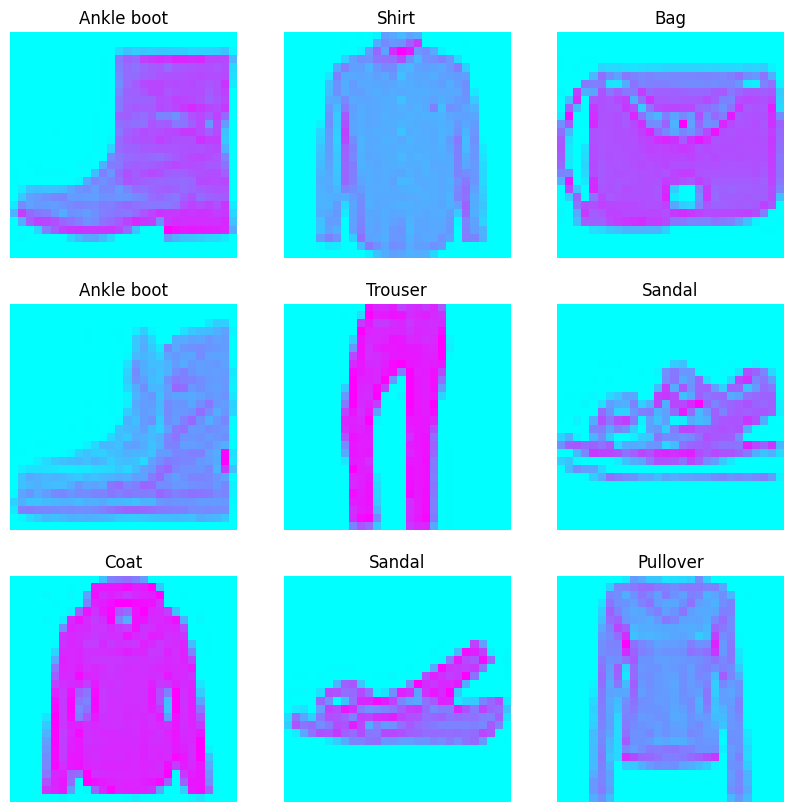

In [17]:
torch.manual_seed(42)

fig = plt.figure(figsize=(10, 10))
cols, rows = (3, 3)
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[idx]
    fig.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off") # отключение осей
    plt.imshow(img.squeeze(), cmap="cool")

In [19]:
class FashionMNISTLogisticRegression(nn.Module):

    def __init__(self, in_features, out_features):
        super(FashionMNISTLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.classifier(x)


In [20]:
def train_loop(dataloader,model,loss_fn,optimizer):
    model.train()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to("cpu"), y.to("cpu")

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

    return avg_loss / num_batches


def test_loop(dataloader, model, loss_fn):
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to("cpu"), y.to("cpu")
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(
        f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


In [21]:
torch.manual_seed(42)


net = FashionMNISTLogisticRegression(1 * 28 * 28, 10).to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_data, batch_size=64, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), num_workers=2)

net

FashionMNISTLogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [22]:
%%time

epochs = 10
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(test_dataloader, net, loss_fn)

Epoch 1
--------------------------------
loss: 2.291149  [    0/60000]
loss: 2.233704  [ 6400/60000]
loss: 2.148534  [12800/60000]
loss: 2.111794  [19200/60000]
loss: 1.962906  [25600/60000]
loss: 1.885889  [32000/60000]
loss: 1.776450  [38400/60000]
loss: 1.658671  [44800/60000]
loss: 1.608623  [51200/60000]
loss: 1.442051  [57600/60000]
Test Error: 
 Accuracy: 0.628300, Avg loss: 1.426215 

Epoch 2
--------------------------------
loss: 1.475104  [    0/60000]
loss: 1.448524  [ 6400/60000]
loss: 1.194727  [12800/60000]
loss: 1.324383  [19200/60000]
loss: 1.074377  [25600/60000]
loss: 1.113122  [32000/60000]
loss: 1.081327  [38400/60000]
loss: 1.025943  [44800/60000]
loss: 1.077351  [51200/60000]
loss: 0.998653  [57600/60000]
Test Error: 
 Accuracy: 0.708200, Avg loss: 0.950341 

Epoch 3
--------------------------------
loss: 0.973252  [    0/60000]
loss: 1.033098  [ 6400/60000]
loss: 0.770982  [12800/60000]
loss: 1.012134  [19200/60000]
loss: 0.825745  [25600/60000]
loss: 0.863402  [

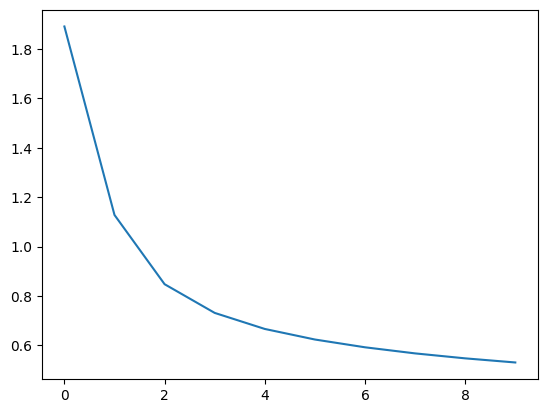

In [23]:
plt.plot(torch.arange(len(train_losses)), train_losses);

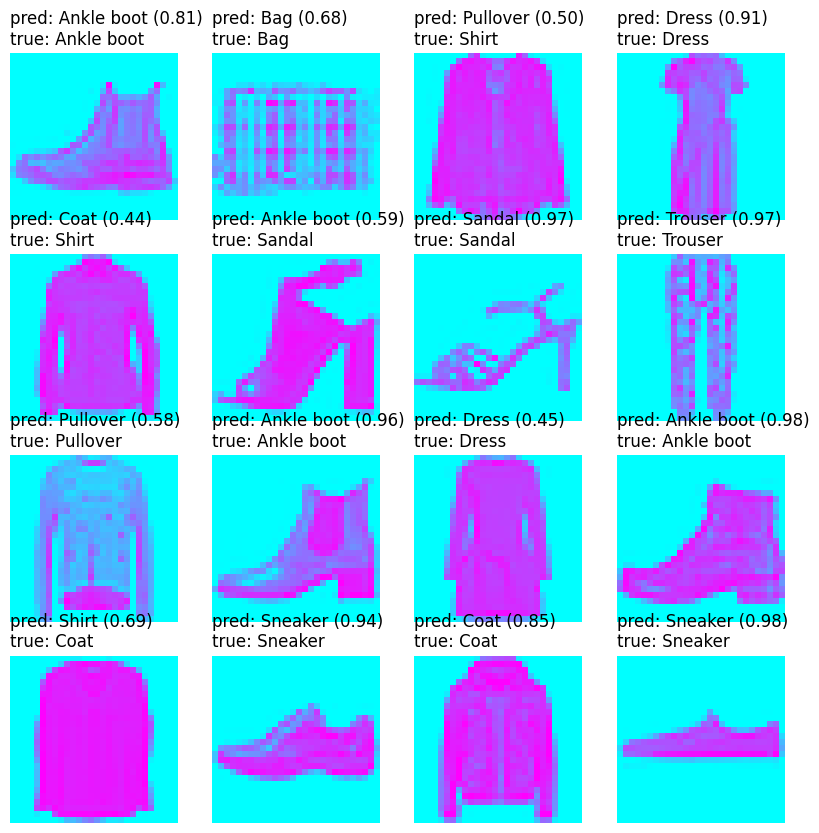

In [25]:
torch.manual_seed(42)
net.eval()

fig = plt.figure(figsize=(10, 10))
cols, rows = (4, 4)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]
    img = img.to("cpu")

    pred = net(img.unsqueeze(0))
    pred_proba = F.softmax(pred, 1).max(1).values.item()
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    plt.imshow(img.squeeze().cpu(), cmap="cool")

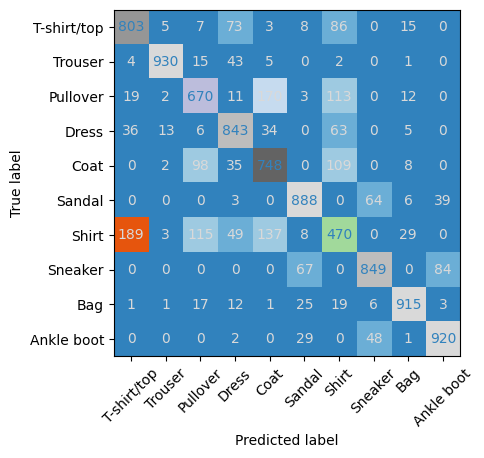

In [31]:
X_test, y_test = next(iter(test_dataloader))
X_test, y_test = X_test.to("cpu"), y_test.to("cpu")

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), y_pred.cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=seaborn.color_palette('tab20c', as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [32]:
test_loop(test_dataloader, net, loss_fn);

Test Error: 
 Accuracy: 0.803600, Avg loss: 0.547586 



In [34]:
torch.save(net, MODELS_DIR / "FashionMNIST-logistic.pth")
net = torch.load(MODELS_DIR / "FashionMNIST-logistic.pth")
net.eval()

FashionMNISTLogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [35]:
class FastFashionMNSITDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = self.dataset.transform

        self._data = self.dataset.data.to(torch.float32)
        if len(self._data.size()) == 3:
            self._data = self._data.unsqueeze(1)

        self._targets = self.dataset.targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, target = self._data[index], self._targets[index]
        if self.transform:
            img = self.transform(img)
        return img, target


class FastDataloader:

    def __init__(self, dataloader, force = False):
        self.dataloader = dataloader
        self._force = force
        self._bathes = [0] * len(self.dataloader)
        self._create_batches()

    @property
    def dataset(self):
        return self.dataloader.dataset

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self._force:
            self._create_batches()
        return self._get_iterator()

    def _create_batches(self):
        for i, batch in enumerate(self.dataloader):
            self._bathes[i] = batch

    def _get_iterator(self):
        for batch in self._bathes:
            yield batch

In [36]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

fast_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Normalize(
        (_data.mean() / 255,), (_data.std() / 255,)), ]),
)

slow_dataset = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
    ]),
)


In [37]:
%%time

fast_dataset = FastFashionMNSITDataset(fast_data)
fast_dataloader = FastDataloader(fast_dataset)

for epoch in range(20):
    for x, y in fast_dataloader:
        pass

CPU times: user 4.04 s, sys: 252 ms, total: 4.29 s
Wall time: 4.37 s


In [38]:
class FashionMNISTConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(FashionMNISTConvNet, self).__init__()
        self.features = nn.Sequential(OrderedDict({
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            "norm2": nn.BatchNorm2d(64),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(64 * 6 * 6, 512),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(512, 128),
            "relu2": nn.ReLU(True),
            "drop2": nn.Dropout(),
            "fc3": nn.Linear(128, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [39]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

transform = transforms.Compose([
    transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
])

fast_train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

fast_test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

fast_train_dataset = FastFashionMNSITDataset(fast_train_data)
fast_test_dataset = FastFashionMNSITDataset(fast_test_data)

fast_train_dataloader = FastDataloader(DataLoader(fast_train_dataset, batch_size=128))
fast_test_dataloader = FastDataloader(DataLoader(fast_test_dataset, batch_size=len(fast_test_data)))

In [40]:
torch.manual_seed(42)

net = FashionMNISTConvNet(1, 10).to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net

FashionMNISTConvNet(
  (features): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU(inplace=True)
    (drop2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(

In [42]:
%%time
# мой компьютер не в силах это посчитать
epochs = 10
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)

Epoch 1
--------------------------------
loss: 0.231667  [    0/60000]
loss: 0.278706  [12800/60000]
loss: 0.229171  [25600/60000]
loss: 0.338924  [38400/60000]
loss: 0.388223  [51200/60000]
Test Error: 
 Accuracy: 0.901400, Avg loss: 0.277447 

Epoch 2
--------------------------------
loss: 0.163208  [    0/60000]
loss: 0.167287  [12800/60000]
loss: 0.221921  [25600/60000]
loss: 0.228358  [38400/60000]
loss: 0.302945  [51200/60000]
Test Error: 
 Accuracy: 0.901800, Avg loss: 0.286292 

Epoch 3
--------------------------------
loss: 0.132504  [    0/60000]
loss: 0.200404  [12800/60000]
loss: 0.187917  [25600/60000]
loss: 0.200179  [38400/60000]
loss: 0.236002  [51200/60000]
Test Error: 
 Accuracy: 0.902500, Avg loss: 0.269750 

Epoch 4
--------------------------------
loss: 0.134886  [    0/60000]
loss: 0.209537  [12800/60000]
loss: 0.215229  [25600/60000]
loss: 0.197047  [38400/60000]
loss: 0.220165  [51200/60000]
Test Error: 
 Accuracy: 0.906100, Avg loss: 0.260570 

Epoch 5
--------

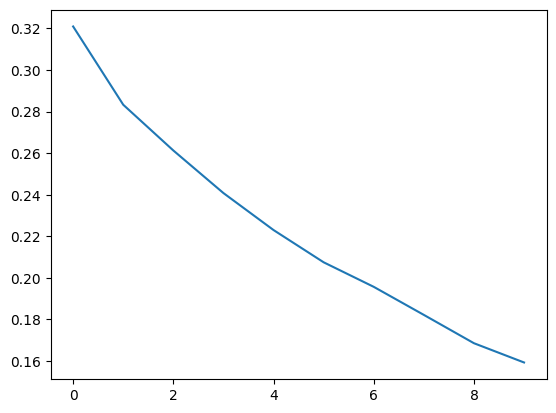

In [43]:
plt.plot(torch.arange(len(train_losses)), train_losses);

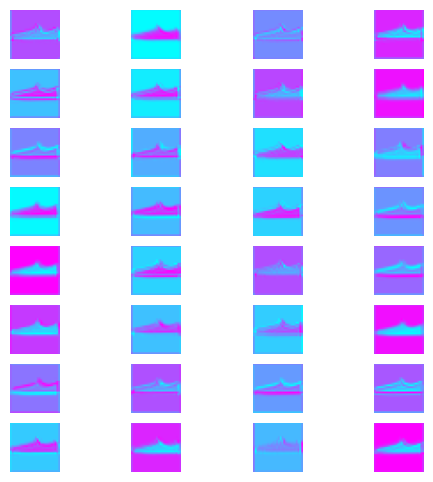

In [46]:
first_conv_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
fig, axes = plt.subplots(8, 4, figsize=(6, 6))
for channel, ax in zip(first_conv_layer(img), axes.flatten()):
    ax.axis("off")
    ax.imshow(channel.detach(), cmap="cool")

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [47]:
_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
).data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_data.data.shape, len(train_data.targets), len(train_data.classes)

100.0%


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), 50000, 10)

In [48]:
fast_train_dataloader = FastDataloader(DataLoader(train_data, batch_size=128, num_workers=2))
fast_test_dataloader = FastDataloader(DataLoader(test_data, batch_size=len(test_data), num_workers=2))

In [49]:
class CIFAR10LogisticRegression(nn.Module):

    def __init__(self, in_features, out_features):
        super(CIFAR10LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.classifier(x)

In [50]:
torch.manual_seed(42)

net = CIFAR10LogisticRegression(3 * 32 * 32, 10).to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

net

CIFAR10LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [51]:
%%time

epochs = 10
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)

Epoch 1
--------------------------------
loss: 2.304840  [    0/50000]
loss: 2.298058  [12800/50000]
loss: 2.296706  [25600/50000]
loss: 2.298362  [38400/50000]
Test Error: 
 Accuracy: 0.153400, Avg loss: 2.297942 

Epoch 2
--------------------------------
loss: 2.300815  [    0/50000]
loss: 2.293453  [12800/50000]
loss: 2.292776  [25600/50000]
loss: 2.294279  [38400/50000]
Test Error: 
 Accuracy: 0.186800, Avg loss: 2.293476 

Epoch 3
--------------------------------
loss: 2.296358  [    0/50000]
loss: 2.288408  [12800/50000]
loss: 2.288386  [25600/50000]
loss: 2.289707  [38400/50000]
Test Error: 
 Accuracy: 0.210700, Avg loss: 2.288452 

Epoch 4
--------------------------------
loss: 2.291348  [    0/50000]
loss: 2.282661  [12800/50000]
loss: 2.283361  [25600/50000]
loss: 2.284291  [38400/50000]
Test Error: 
 Accuracy: 0.223900, Avg loss: 2.282563 

Epoch 5
--------------------------------
loss: 2.285487  [    0/50000]
loss: 2.275835  [12800/50000]
loss: 2.277334  [25600/50000]
loss:

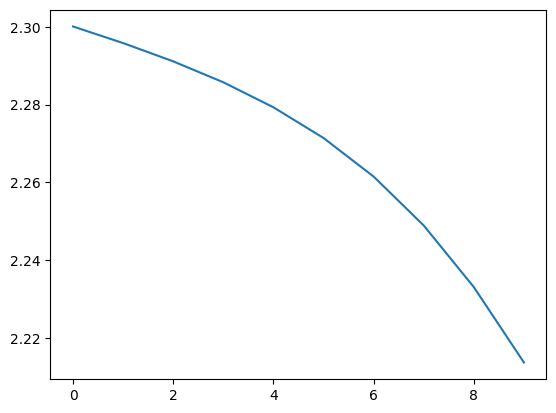

In [52]:
plt.plot(torch.arange(len(train_losses)), train_losses);

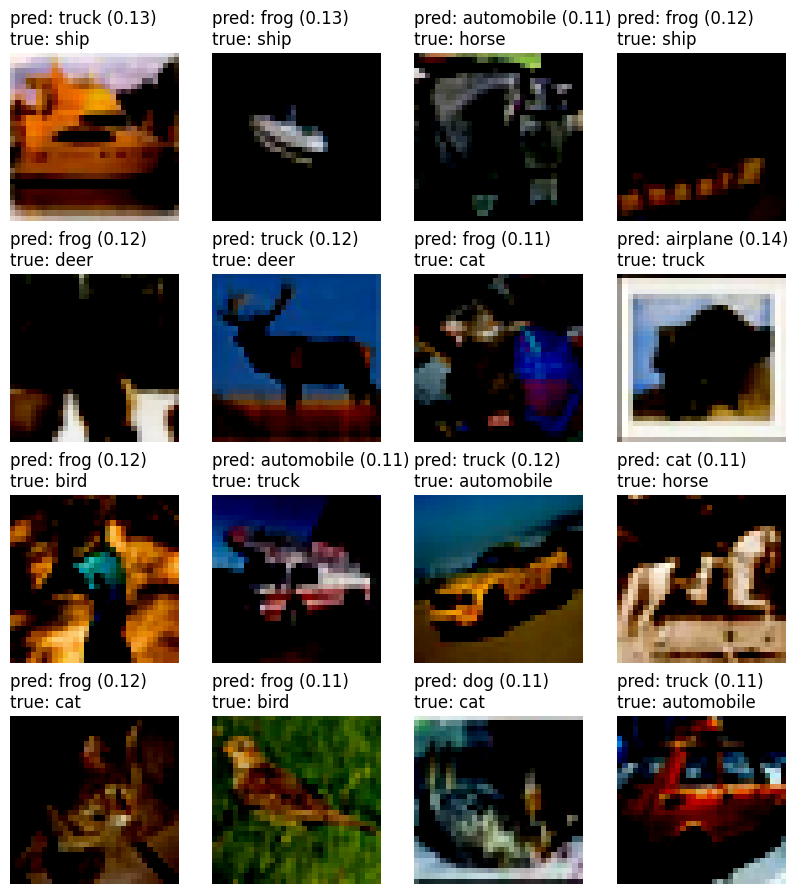

In [53]:
torch.manual_seed(42)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]

    pred = net(img.unsqueeze(0).to("cpu"))
    pred_proba = F.softmax(pred, 1).max(1).values.item()
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1).cpu())

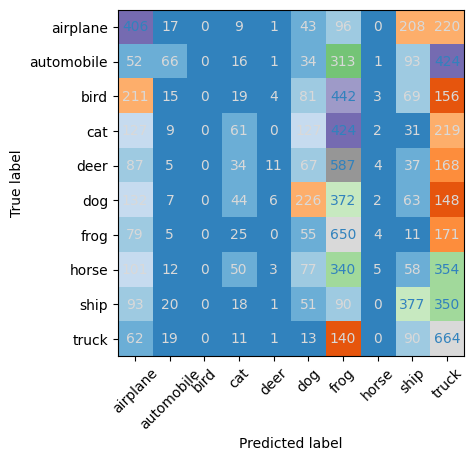

In [54]:
X_test, y_test = next(iter(fast_test_dataloader))
X_test, y_test = X_test.to("cpu"), y_test.to("cpu")

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), y_pred.cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=seaborn.color_palette('tab20c', as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [58]:
import warnings
warnings.filterwarnings("ignore")
print(metrics.classification_report(y_test.cpu(), y_pred.cpu(), target_names=train_data.classes))

              precision    recall  f1-score   support

    airplane       0.30      0.41      0.35      1000
  automobile       0.38      0.07      0.11      1000
        bird       0.00      0.00      0.00      1000
         cat       0.21      0.06      0.09      1000
        deer       0.39      0.01      0.02      1000
         dog       0.29      0.23      0.25      1000
        frog       0.19      0.65      0.29      1000
       horse       0.24      0.01      0.01      1000
        ship       0.36      0.38      0.37      1000
       truck       0.23      0.66      0.34      1000

    accuracy                           0.25     10000
   macro avg       0.26      0.25      0.18     10000
weighted avg       0.26      0.25      0.18     10000



### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:16<00:00, 81.74it/s]


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)